In [1]:
%matplotlib inline



# Modifying data in-place

It is often necessary to modify data once you have loaded it into memory.
Common examples of this are signal processing, feature extraction, and data
cleaning. Some functionality is pre-built into MNE-python, though it is also
possible to apply an arbitrary function to the data.


In [2]:
import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

Load an example dataset, the preload flag loads the data into memory now



In [4]:
data_path = op.join(mne.datasets.sample.data_path(), 'MEG',
                    'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(data_path, preload=True)
raw = raw.crop(0, 10)
print(raw)

Opening raw data file /home/victormp/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Raw | sample_audvis_raw.fif, 376 x 6007 (10.0 s), ~20.9 MB, data loaded>


## Signal processing

Most MNE objects have in-built methods for filtering:



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 1983 samples (3.302 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 10

Text(0.5, 1.0, 'Band-pass filtered data')

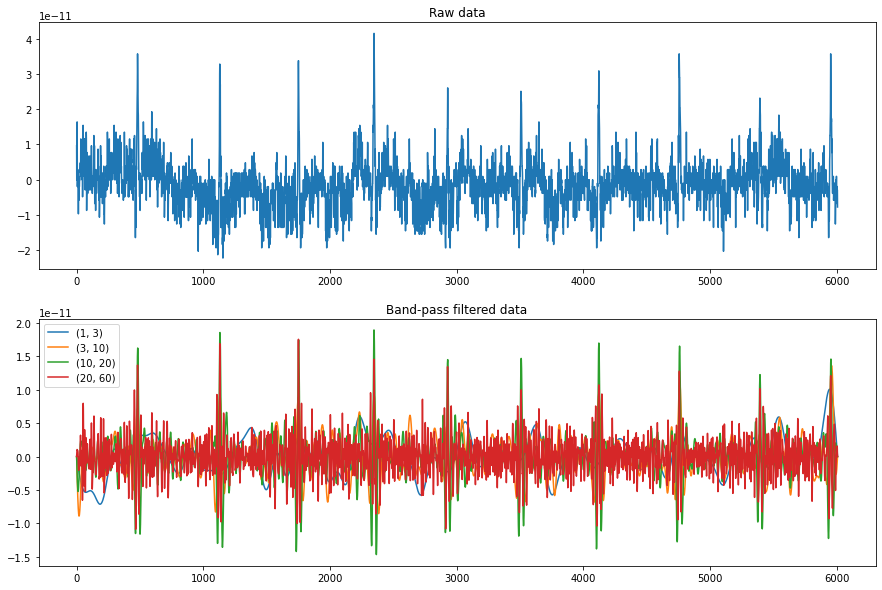

In [5]:
filt_bands = [(1, 3), (3, 10), (10, 20), (20, 60)]
_, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))
data, times = raw[0]
_ = ax.plot(data[0])
for fmin, fmax in filt_bands:
    raw_filt = raw.copy()
    raw_filt.filter(fmin, fmax, fir_design='firwin')
    _ = ax2.plot(raw_filt[0][0][0])
ax2.legend(filt_bands)
ax.set_title('Raw data')
ax2.set_title('Band-pass filtered data')

In addition, there are functions for applying the Hilbert transform, which is
useful to calculate phase / amplitude of your signal.



In [6]:
# Filter signal with a fairly steep filter, then take hilbert transform

raw_band = raw.copy()
raw_band.filter(12, 18, l_trans_bandwidth=2., h_trans_bandwidth=2.,
                fir_design='firwin')
raw_hilb = raw_band.copy()
hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
raw_hilb.apply_hilbert(hilb_picks)
print(raw_hilb[0][0].dtype)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 11.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 19.00 Hz)
- Filter length: 991 samples (1.650 sec)

complex128


Finally, it is possible to apply arbitrary functions to your data to do
what you want. Here we will use this to take the amplitude and phase of
the hilbert transformed data.

<div class="alert alert-info"><h4>Note</h4><p>You can also use ``envelope=True`` in the call to
          :meth:`mne.io.Raw.apply_hilbert` to do this automatically.</p></div>




Text(0.5, 1.0, 'Phase of frequency band')

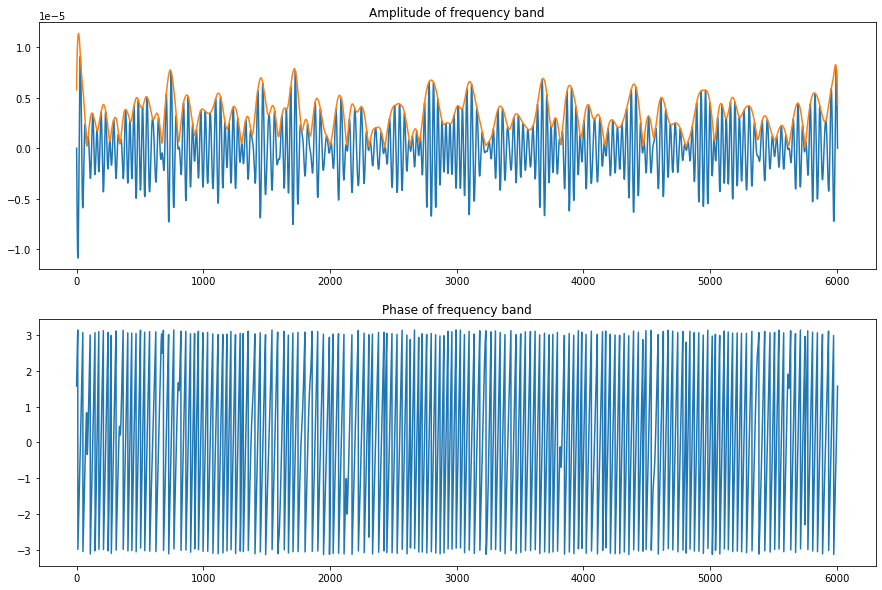

In [7]:
# Take the amplitude and phase
raw_amp = raw_hilb.copy()
raw_amp.apply_function(np.abs, hilb_picks)
raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle, hilb_picks)

_, (a1, a2) = plt.subplots(2, 1, figsize=(15, 10))
a1.plot(raw_band[hilb_picks[0]][0][0].real)
a1.plot(raw_amp[hilb_picks[0]][0][0].real)
a2.plot(raw_phase[hilb_picks[0]][0][0].real)
a1.set_title('Amplitude of frequency band')
a2.set_title('Phase of frequency band')